### Access the file stored in drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as data
from torchvision.utils import make_grid
from torchvision import transforms
from collections import Counter
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import random
import os
%matplotlib inline

In [3]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cpu


In [4]:
# Hyperparameter
NUM_EPOCHS = 20
BATCH_SIZE = 4
LR = 0.001

In [18]:
train_dir = os.path.join(os.getcwd(),"drive/MyDrive/HW3/train/images")
test_dir = os.path.join(os.getcwd(),"drive/MyDrive/HW3/test/test")
print(train_dir)

/content/drive/MyDrive/HW3/train/images


In [6]:
TRANSFORM_IMG = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(100)
    ])

### Load all the data

In [7]:
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=1)

### Information of dataset

['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
[0, 1, 2, 3, 4, 5]
[('/content/drive/MyDrive/HW3/train/images/crazing/crazing_1.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_10.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_100.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_101.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_102.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_103.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_104.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_105.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_106.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_107.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_108.jpg', 0), ('/content/drive/MyDrive/HW3/train/images/crazing/crazing_109.jpg', 0), ('/content/drive/MyDrive/HW3/trai

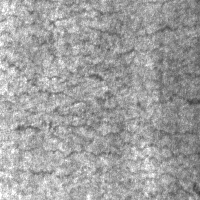

RGB


In [8]:
x = list(train_data.class_to_idx.values())
print(train_data.classes)
print(x)
print(train_data.imgs)
print(dict(Counter(train_data.targets)))
im = Image.open(train_data.imgs[0][0])
display(im)
print(im.mode)

In [9]:
def visualize_batch(batch, classes, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type),
        figsize=(10, 10))
    # loop over the batch size
    for i in range(0, BATCH_SIZE):
        # create a subplot
        ax = plt.subplot(2, 4, i + 1)
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        # grab the label id and get the label from the classes list
        idx = batch[1][i]
        label = classes[idx]
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
    # show the plot
    plt.tight_layout()
    plt.show()

### Plot different types of surface defect


Visualizing some random training batch...


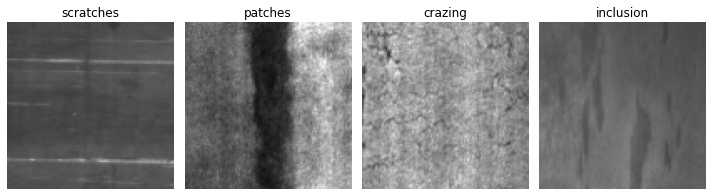

In [10]:
trainBatch = next(iter(train_data_loader))
print("Visualizing some random training batch...")
visualize_batch(trainBatch, train_data.classes, "train")

### Define the CNN architecture
Tips:
- try different size of out_channels/ conv layer/ kernel

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # image shape is 3 * 100 * 100, where 3 is  color channel
        # 100 * 100 is the image size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=18, kernel_size=5)    # output shape = 18 * 96 * 96
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                       # output shape = 18 * 48 * 48
        # intput shape is 18 * 48 * 48
        self.conv2 = nn.Conv2d(in_channels=18, out_channels=18, kernel_size=5)    # output shape = 18 * 44 * 44
        # add another max pooling, output shape = 18 * 22 * 22
        self.fc1 = nn.Linear(18*22*22, 100)
        self.fc2 = nn.Linear(100, 50)
        # last fully connected layer output should be same as classes
        self.fc3 = nn.Linear(50, 6)

        
    def forward(self, x):
        # first conv
        x = self.pool(F.relu(self.conv1(x)))
        # second conv
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
net = ConvNet()

In [12]:
# Define loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

In [13]:
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 1.784
[1,    40] loss: 1.787
[1,    60] loss: 1.806
[1,    80] loss: 1.805
[1,   100] loss: 1.797
[1,   120] loss: 1.787
[1,   140] loss: 1.792
[1,   160] loss: 1.789
[1,   180] loss: 1.782
[1,   200] loss: 1.787
[1,   220] loss: 1.784
[1,   240] loss: 1.805
[1,   260] loss: 1.779
[1,   280] loss: 1.772
[1,   300] loss: 1.778
[1,   320] loss: 1.799
[1,   340] loss: 1.773
[1,   360] loss: 1.784
[2,    20] loss: 1.762
[2,    40] loss: 1.773
[2,    60] loss: 1.779
[2,    80] loss: 1.772
[2,   100] loss: 1.764
[2,   120] loss: 1.754
[2,   140] loss: 1.731
[2,   160] loss: 1.767
[2,   180] loss: 1.676
[2,   200] loss: 1.687
[2,   220] loss: 1.717
[2,   240] loss: 1.752
[2,   260] loss: 1.739
[2,   280] loss: 1.724
[2,   300] loss: 1.711
[2,   320] loss: 1.737
[2,   340] loss: 1.688
[2,   360] loss: 1.696
[3,    20] loss: 1.667
[3,    40] loss: 1.718
[3,    60] loss: 1.654
[3,    80] loss: 1.593
[3,   100] loss: 1.734
[3,   120] loss: 1.605
[3,   140] loss: 1.556
[3,   160] 

In [14]:
# Save our trained model
PATH = '/content/drive/MyDrive/HW3/HW3_model.pth'
torch.save(net.state_dict(), PATH)

In [29]:
model_test = ConvNet()
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

ConvNet(
  (conv1): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(18, 18, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=8712, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
)

In [30]:
testBatch = next(iter(test_data_loader))
images, labels = testBatch
outputs = model_test(images)
_, predicted = torch.max(outputs, 1)
print(predicted)
print('Predicted: ', ' '.join(f'{train_data.classes[predicted[j]]:5s}'
                              for j in range(4)))

tensor([3, 4, 5, 2])
Predicted:  pitted_surface rolled-in_scale scratches patches


In [33]:
correct = 0
total = 0
res = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i in range(360):
        tpath = os.path.join(test_dir+'/',str(i)+'.jpg')
        fopen = Image.open(tpath)
        image = TRANSFORM_IMG(fopen)
        # calculate outputs by running images through the network
        # images, labels = data
        image = image.unsqueeze(0)
        outputs = model_test(image)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        # you can modified the following code to show accuracy if you have split some validation set 
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        # print('Predicted: ', ' '.join(f'{train_data.classes[predicted[j]]:5s}'
        #                        for j in range(len(predicted))))
        for j in range(len(predicted)):
          res.append(str(train_data.classes[predicted[j]]))
print('Predict finished')
# print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Predict finished


In [34]:
df_ans = pd.DataFrame(res, columns=['Category'])
df_ans.to_csv('/content/drive/MyDrive/HW3/mySubmission.csv', index_label='Id')

### Some tips for getting better result
- image size (pick the best suitable size to input)
- different CNN architecture
- data augmentation
- reasonable hyperparameter tuning strategy